# HOML - Chapter 9: Unsupervised Learning Techniques

## Exercise 10

The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the sklearn.datasets.fetch_olivetti_faces() function.

Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.

Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter).

Visualize the clusters: do you see similar faces in each cluster?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's begin by importing the Olivetti dataset and reading the description so that we can have a better sense of the dataset, including the type and amount of images.

In [2]:
# Import the Olivetti dataset
from sklearn.datasets import fetch_olivetti_faces

olvti = fetch_olivetti_faces()

In [3]:
# Print a description of the dataset
print(olvti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

As mentioned in the description, this is a fairly small dataset that is more interesting from an unsupervised/semi-supervised perspective than supervised. They're also only 64 x 64 grey images, so there shouldn't be a great deal of computational power required.  WIth 40 subjects/classes and 400 images, we have 10 images per person.

For the next step, we'll use stratified sampling to split the dataset into training, validation, and test sets, as the author suggests, because we want to ensure that the same number of images per person are present in each dataset. As usch, our test set will have 40 images, 10% of the total and one image per person. Our validation set will have 80 images or 2 images per class. 

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split 40 randomly chosen test images from the dataset, choosing one per class using stratified sampling
ss_splt = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=99)
train_val_idx, test_idx = next(ss_splt.split(olvti.data, olvti.target))
X_train_val = olvti.data[train_val_idx]
y_train_val = olvti.target[train_val_idx]
X_test = olvti.data[test_idx]
y_test = olvti.target[test_idx]

In [5]:
# From the remaining 360 images, randomly choose 80, two per class, using stratified sampling
ss_splt = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=99)
train_idx, val_idx = next(ss_splt.split(X_train_val, y_train_val))
X_train = X_train_val[train_idx]
y_train = y_train_val[train_idx]
X_val = X_train_val[val_idx]
y_val = y_train_val[val_idx]

In [6]:
# Confirm that the shape of each set is correct
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


It may be a good idea to use PCA to reduce the dimensionality of our dataset and speed up the clustering process. While we may lose some information as a result, we could save substantial time. Let's graph the variance against the number of dimensions to see where 95% and 99% of the variance is explained. 

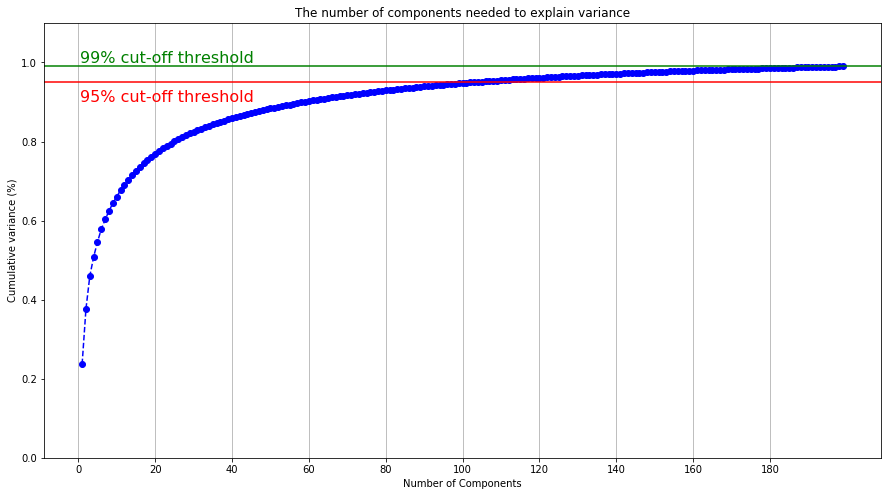

In [7]:
# Plotting variance against dimensions
# Code borrowed from: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(0.99).fit(X_train)
plt.rcParams["figure.figsize"] = (15,8)

fig, ax = plt.subplots()
xi = np.arange(1, 200, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 200, step=20)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.90, '95% cut-off threshold', color = 'red', fontsize=16)

plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(0.5, 0.999, '99% cut-off threshold', color = 'green', fontsize=16)

ax.grid(axis='x')
plt.show()

In [8]:
# Fit PCA to the training, validation, and test dataset
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

It appears that 99% of the variance is explained by 199 components. It's a substantial reduction in components considering that the images are each 64 x 64.   

Next, we need to cluster our images using KMeans. The author suggests that we may need to use a substantial number of clusters. Considering that we've reduced the number of components considerably, we should be able to quickly run through a wide range of clusters and then use the silhouette score of each to find the ideal k.    

In [9]:
# Fit KMeans for every 4th value between 4 and 204.
from sklearn.cluster import KMeans

k_range = range(4, 204, 4)
kmeans_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=99).fit(X_train_pca)
    kmeans_k.append(kmeans)

k=4
k=8
k=12
k=16
k=20
k=24
k=28
k=32
k=36
k=40
k=44
k=48
k=52
k=56
k=60
k=64
k=68
k=72
k=76
k=80
k=84
k=88
k=92
k=96
k=100
k=104
k=108
k=112
k=116
k=120
k=124
k=128
k=132
k=136
k=140
k=144
k=148
k=152
k=156
k=160
k=164
k=168
k=172
k=176
k=180
k=184
k=188
k=192
k=196
k=200


As the author suggested, the silhouette method is a better method to determining the best k value. Below, we'll plot the silhouette score against k values to see where the silhouette score peaks. 

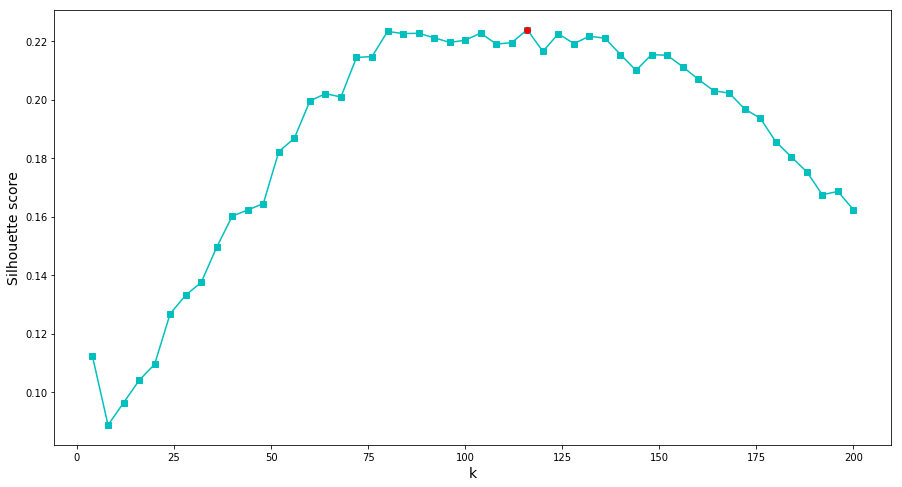

In [10]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(15, 8))
plt.plot(k_range, silhouette_scores, "cs-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "ro")
plt.show()

In [11]:
# List the best k value
best_k

116

We achieve our best score at k = 116. Just to see how much easier it is to determine the best k value visually using this technique rather than inertia, let's also plot inertia against k.  

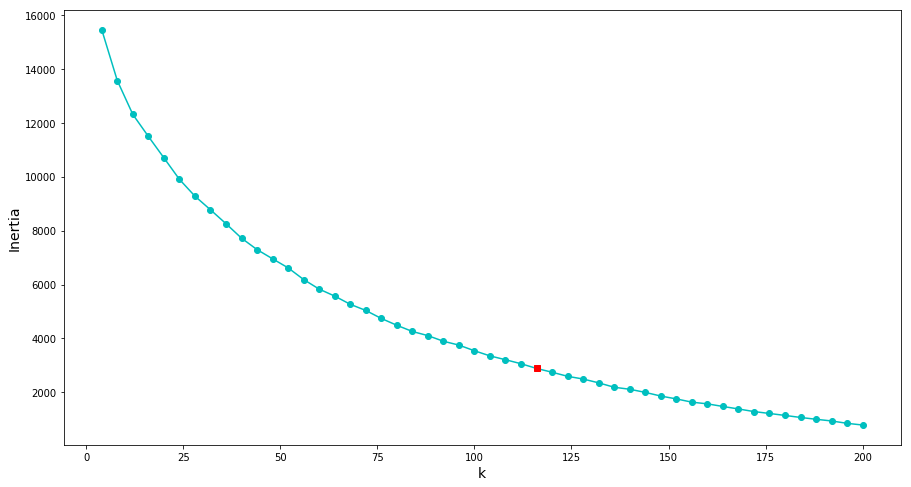

In [12]:
# Plot inertia against k.
inertias = [model.inertia_ for model in kmeans_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(15, 8))
plt.plot(k_range, inertias, "co-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

In [13]:
best_model = kmeans_k[best_index]
print(best_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=116, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=99, tol=0.0001, verbose=0)


As the graph demnostrates, inertia isn't always the best approach to determining k. k=116 doesn't stand out from the other values, so there isn't much reason to choose one above the other.  

Finally, let's display the clusters of the training set to see how well the algorithm did. 

Cluster 0


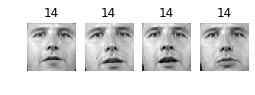

Cluster 1


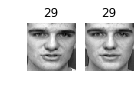

Cluster 2


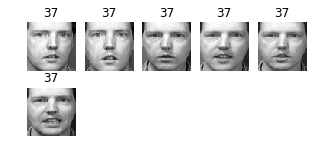

Cluster 3


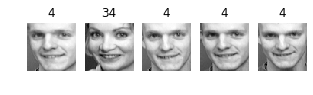

Cluster 4


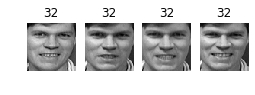

Cluster 5


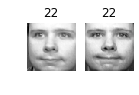

Cluster 6


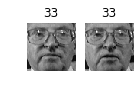

Cluster 7


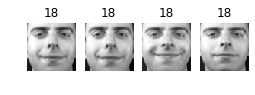

Cluster 8


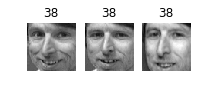

Cluster 9


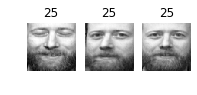

Cluster 10


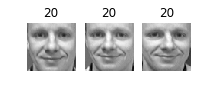

Cluster 11


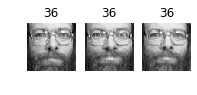

Cluster 12


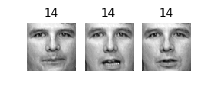

Cluster 13


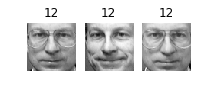

Cluster 14


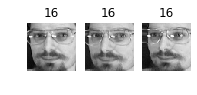

Cluster 15


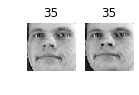

Cluster 16


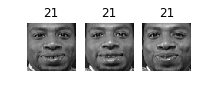

Cluster 17


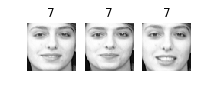

Cluster 18


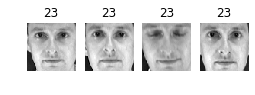

Cluster 19


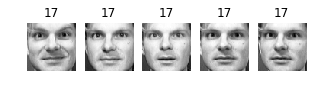

Cluster 20


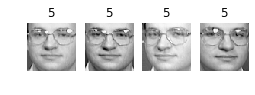

Cluster 21


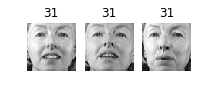

Cluster 22


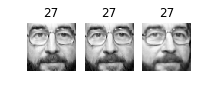

Cluster 23


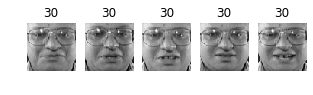

Cluster 24


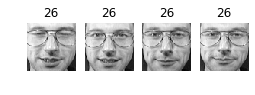

Cluster 25


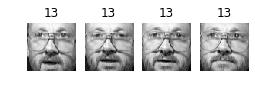

Cluster 26


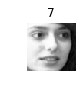

Cluster 27


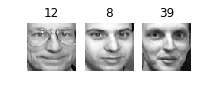

Cluster 28


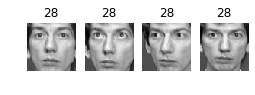

Cluster 29


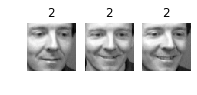

Cluster 30


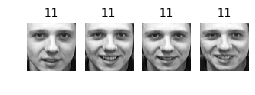

Cluster 31


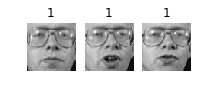

Cluster 32


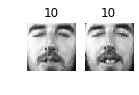

Cluster 33


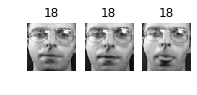

Cluster 34


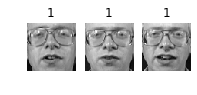

Cluster 35


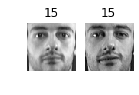

Cluster 36


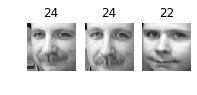

Cluster 37


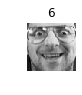

Cluster 38


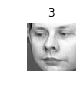

Cluster 39


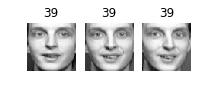

Cluster 40


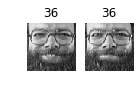

Cluster 41


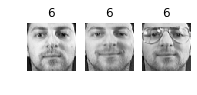

Cluster 42


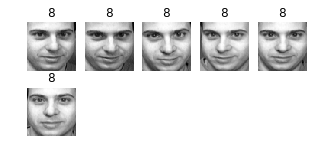

Cluster 43


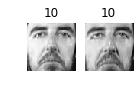

Cluster 44


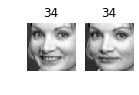

Cluster 45


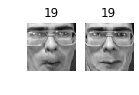

Cluster 46


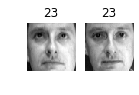

Cluster 47


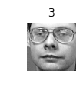

Cluster 48


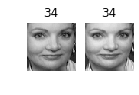

Cluster 49


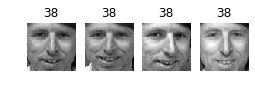

Cluster 50


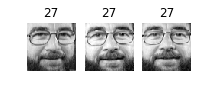

Cluster 51


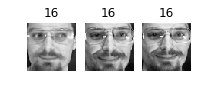

Cluster 52


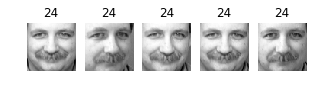

Cluster 53


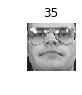

Cluster 54


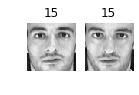

Cluster 55


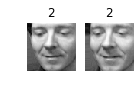

Cluster 56


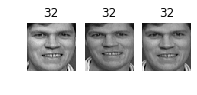

Cluster 57


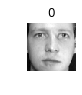

Cluster 58


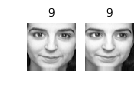

Cluster 59


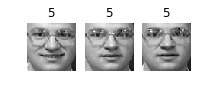

Cluster 60


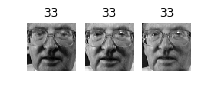

Cluster 61


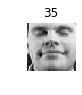

Cluster 62


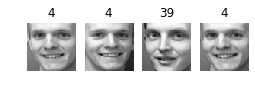

Cluster 63


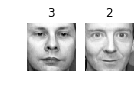

Cluster 64


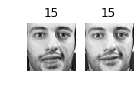

Cluster 65


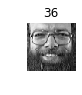

Cluster 66


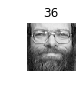

Cluster 67


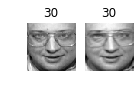

Cluster 68


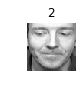

Cluster 69


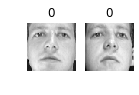

Cluster 70


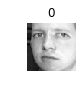

Cluster 71


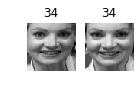

Cluster 72


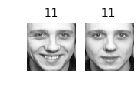

Cluster 73


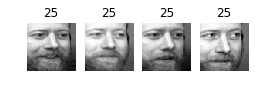

Cluster 74


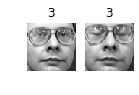

Cluster 75


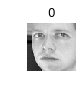

Cluster 76


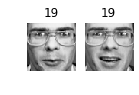

Cluster 77


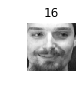

Cluster 78


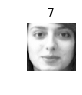

Cluster 79


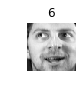

Cluster 80


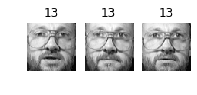

Cluster 81


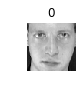

Cluster 82


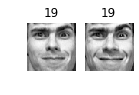

Cluster 83


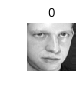

Cluster 84


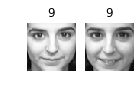

Cluster 85


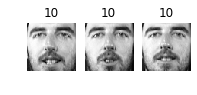

Cluster 86


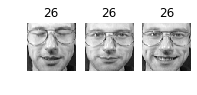

Cluster 87


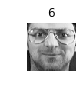

Cluster 88


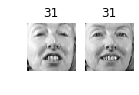

Cluster 89


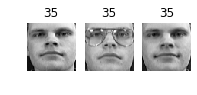

Cluster 90


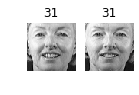

Cluster 91


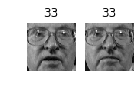

Cluster 92


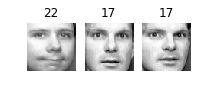

Cluster 93


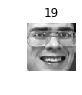

Cluster 94


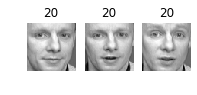

Cluster 95


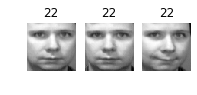

Cluster 96


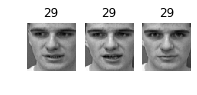

Cluster 97


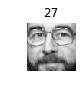

Cluster 98


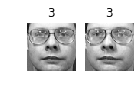

Cluster 99


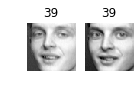

Cluster 100


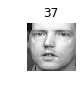

Cluster 101


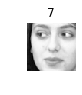

Cluster 102


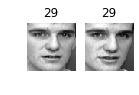

Cluster 103


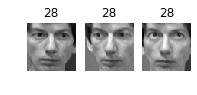

Cluster 104


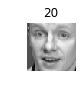

Cluster 105


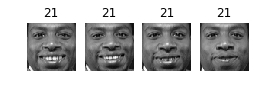

Cluster 106


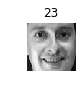

Cluster 107


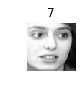

Cluster 108


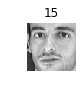

Cluster 109


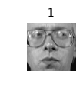

Cluster 110


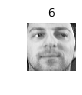

Cluster 111


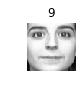

Cluster 112


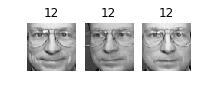

Cluster 113


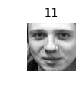

Cluster 114


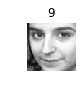

Cluster 115


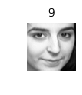

In [14]:
def plot_faces(faces, labels, n_cols=5):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster].reshape(-1, 64, 64)
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

As we can see, the algorithm did a mixed job in clustering the classes accurately. In a few instances, it did manage to cluster 6 faces together accurately. In a couple of other instances, it grouped together faces from different classes. However, because our silhouette score suggested that we use 116 clusters, we ended up with the majority of our clusters containing either 1, 2, or 3 faces. Often, a slight turn to one direction or a change in expression was enough for a picture to be classified to a separate cluster. 